# Evaluating Local Election Campaigns

 - Robert Sinclair, Campaign Lab 

Election organisers would like to know what makes a successful local election campaign.

The initial problem was stated as finding two similar constituencies that performed very differently, so that we can retrospectively find out what was done differently. Is this possible? Will it be useful?

Internal Labour Party election analysis is often based on anecdotal information, can we approach these problems in a more scientific way?

This research will be included in the Labour general election analysis report, commissioned by Ed Miliband.

## Methodology

This problem can be split into three main elements. We need:

- A way to score a constituency's result
- A way to characterise a constituencies electorate
- A methodology to compare constituencies' scores, taking into account their characteristics


In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# collection of functions to read in useful datasets
import campaignlabprojects as clp

# Config
sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Score constituencies

By reading in the election results, we can calculate various scoring metrics for the labour campaing in each constituency. 

- `base` : Simply the % share of votes Labour received in a constituency
- `diff` : Difference in number of votes between an election year and the comparisson year
- `uns` : Swing to/from labour in a constituency minus the national average swing
- `mrp` : Compare the Labour vote share with the YOUGOV MRP poll carried out 4 weeks before an election, only available for GE17 and GE19



In [2]:
election_results = clp.read_in_election_results()

In [3]:
#Pick year of interest, and one to compare with (neccesary for some of the scoring methods)
year = 19 # 2019 election
compare_year = 17 # normally the previous election year

In [4]:
base = pd.DataFrame(election_results[year]['lab_pc'],
                    index=election_results[year].index)

diff = clp.score_campaigns_difference(election_results[year], 
                                      election_results[compare_year])

uns  = clp.score_campaigns_uns(election_results[year], 
                               election_results[compare_year])

mrp  = clp.score_campaigns_mrp(election_results[year])

In [5]:
# Compile all scoring metrics into one database `scores`
scores = pd.concat( [election_results[year]['Constituency'],
                     uns['difference'],
                     base['lab_pc'], 
                     diff['difference'],
                     mrp['difference'] ],
                    axis=1, verify_integrity=True, sort=True)
scores.columns = ['Constituency','uns','base','diff','mrp']
scores.sort_values('uns',ascending=False).head(10)

,Constituency,uns,base,diff,mrp
E14000589,Bradford West,0.115483,0.762206,4292.0,0.222206
E14000884,Portsmouth South,0.076008,0.486410,4778.0,0.066410
E14000958,Southport,0.063657,0.389518,3140.0,0.079518
E14000780,Leeds North West,0.045321,0.486395,3555.0,-0.003605
E14000887,Putney,0.043549,0.451384,3655.0,0.111384
E14000619,Canterbury,0.032513,0.482724,3446.0,0.012724
E14000634,Chingford & Woodford Green,0.019182,0.458653,1581.0,0.048653
E14000762,Isle of Wight,0.012970,0.242847,957.0,0.002847
E14000808,Manchester Gorton,0.012863,0.776361,-502.0,0.106361
E14000555,Bethnal Green & Bow,0.009142,0.727387,1083.0,0.117387


In [6]:
#ax = sns.scatterplot(scores['base'],scores['uns'])

In [7]:
#sns.scatterplot(scores['uns'],scores['mrp'])

In [8]:
# seats that labour won by, or were within a certain percentage of winning
marginals = clp.calc_marginal_within(0.10,election_results[compare_year])

## Characterise constituencies

We use the publicly available 2011 census data, broken down by constituency, to characterise the electorate by its demographic makeup.

The features chosen are based on intuition of campaigners I spoke to and a PCA of voting intentions. This choice is currently fairly arbitrary and could be investigated further.

A basic assumption of this approach is that all voters with the same demographic information will vote the same way; this also implies no geographic or historical voting dependence.

In [9]:
census = clp.read_in_census()

In [10]:
features = ['c11PopulationDensity',
            'c11HouseOwned',
            'c11CarsNone',
            'c11EthnicityWhite',
            'c11Unemployed',
            'c11Retired',
            'c11FulltimeStudent',
            'c11Age65to74',
            'c11DeprivedNone']

In [11]:
demographic_data = census[features]
demographic_data.head()

,c11PopulationDensity,c11HouseOwned,c11CarsNone,c11EthnicityWhite,c11Unemployed,c11Retired,c11FulltimeStudent,c11Age65to74,c11DeprivedNone
ons_id,,,,,,,,,
E14000530,19.614660,65.426048,15.825351,85.533381,3.637000,10.325348,6.690939,7.028348,47.943774
E14000531,17.483482,75.594167,19.131244,93.128849,4.553607,18.657412,6.162344,11.750721,39.975178
E14000532,18.709288,74.080473,16.001903,90.433891,3.039963,14.139160,6.895702,8.780321,54.415484
E14000533,7.051190,72.468212,21.039414,98.388767,4.261173,16.989668,5.294369,10.090689,40.566761
E14000534,1.507467,75.970149,10.346654,97.748466,2.468100,18.684355,5.549608,12.340259,51.468464


### Collect census and demographic data

In [12]:
# only want rows we have election data for
demographic_data = demographic_data.loc[election_results[year].index]

# only want constituencies we have complete data for
demographic_data = demographic_data.dropna()

# Speaker seats have incomplete voting data
speaker_seats = census.index[census['constituency_name'].isin(['Chorley', 'Buckingham'])]
demographic_data = demographic_data.drop(speaker_seats)

loss = set(census.index) - set(demographic_data.index)
print('Loss =',len(loss))

Loss = 79


In [13]:
# Make some lookup containers
constits_id = demographic_data.index
constits_name = list(census.loc[constits_id]['constituency_name'])
id_to_name = {id_:name for id_,name in zip(constits_id, constits_name)}
name_to_id = {name:id_ for id_,name in zip(constits_id, constits_name)}
id_to_index = {onsid:i for i,onsid in enumerate(constits_id)}
name_to_index = {name:i for i,name in enumerate(constits_name)}

scores = scores.loc[constits_id] # only interested in these constits now

We can now see the spread of constituencies based on their demographics.

The graph below shows constituencies close to similar constituencies. Do not read too much into the axes. Points are coloured by their labour swing relative to the national labour swing.

In [60]:
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

def visualise_demographics(demographic_data, Embed=Isomap, colours=None, labels=[]):
    """
    demographic_data: Array-like, shape (n_samples, n_features)
    Embed: SKLearn Embedding class
    colours: List-like, shape (n_samples)
    labels: List of constituency names to label
    """
    Ndim = 2
    embedding = Embed(n_components=Ndim)
    X_transformed = embedding.fit_transform(
        preprocessing.scale(demographic_data))
    x = pd.Series(X_transformed[:,0])
    y = pd.Series(X_transformed[:,1])

    plt.figure(figsize=(8,8))
    ax = sns.scatterplot(x=x, y=y, hue=colours, palette='RdYlBu_r')

    for constit in labels:
        ax.text(x[name_to_index[constit]], 
                y[name_to_index[constit]],
                constit)
        
    if Embed == PCA:
        df = pd.DataFrame(columns=range(Ndim),
                          index=demographic_data.columns)
        for axis in range(Ndim):
            print("axis:", axis)
            order = np.argsort(-abs(embedding.components_[axis]))
            for i in order[:3]:
                print(demographic_data.columns[i], embedding.components_[axis,i])
            print()    

In [61]:
#name_to_id

axis: 0
c11HouseOwned -0.38004482926088834
c11CarsNone 0.37583399773545767
c11Age65to74 -0.36240874870333917

axis: 1
c11DeprivedNone -0.6328652889828424
c11Unemployed 0.49741162179902826
c11Retired 0.3582359138976306



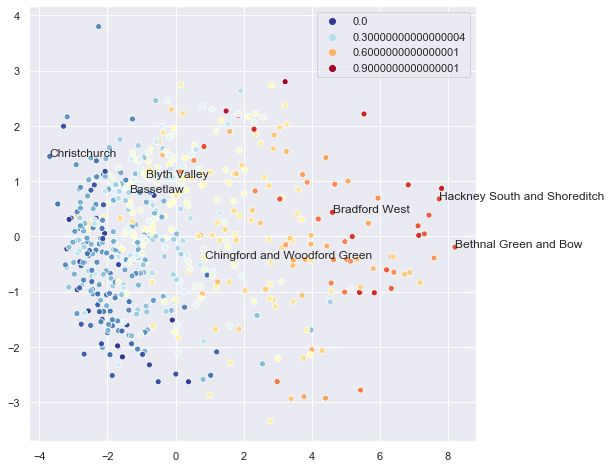

In [62]:
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

labels = ['Bethnal Green and Bow', 'Hackney South and Shoreditch',
          'Christchurch','Bradford West','Bassetlaw',
          'Blyth Valley','Chingford and Woodford Green']
colours = np.array(scores['base'])

visualise_demographics(demographic_data, Embed=PCA, 
                       colours=colours, labels=labels)

axis: 0
c11HouseOwned -0.38004482926088806
c11CarsNone 0.37583399773545767
c11Age65to74 -0.3624087487033394

axis: 1
c11DeprivedNone -0.6328652889828427
c11Unemployed 0.4974116217990284
c11Retired 0.35823591389763054



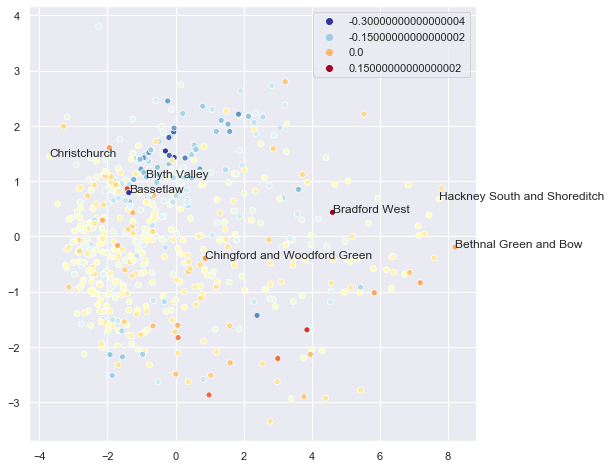

In [63]:
colours = np.array(scores['uns'])

visualise_demographics(demographic_data, Embed=PCA, 
                       colours=colours, labels=labels)

## Conceive a metric for the success of a local campaign

All constituencies are compared with each other.

We calculate a 'distance', $r_{ij}$, between constituencies according their demographics. Similar constituencies, based on the features chosen above, will have a small distance between them.

We then calculate the relative swing between each campaign.

This relative score is divided by the distance between each constituency. Our confidence in a constituencies campaign is the sum of this value between all other constituencies.

For example, if constituency A scored much better than constituency B, and they are very similar in demographics, A will receive a positive contribution and B will receive a negative one. 

Note that this gives us a confidence that a campaign was successful, not an absolute estimate of its success.

$$\textrm{Success}_j = \sum_{i} \frac{ \textrm{swing}_i - \textrm{swing}_j }{ r_{ij} }$$

### Euclidian Distance

If we are $k$ demographic features, $f^k$, that characterise a constituency, the distance $r$ between two constituencies $i$ and $j$ is:

$$ r^{\rm{Euclidian}}_{ij} = \sum_{k}  |f_i^k - f_j^k| $$

### Rescaled distance

We may want to discard constituencies that are very different, or give more weight constituencies that are closer together.

We could introduce a cutoff, $r_c$, beyond which we stop comparing constituencies:

$$ r^{\rm{cut}}_ij =
\begin{cases}
 r^{\rm{Euclidian}}_{ij} \; &\rm{if} \; r^{\rm{Euclidian}}_{ij} < r_c , \\
 \infty & \rm{else}
 \end{cases} $$
 
This tends to create instabilities in the model, as we will see later, a better approach would be to use the euclidian distance as an exponent:

$$ r^{\rm{exp}}_{ij} = n ^ {\; r^{\rm{Euclidian}}_{ij}} $$

In [18]:
# I also normalise each feature to give them equal weighting.
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances

def distance(X):
    X_scaled = preprocessing.scale(X)
    return pairwise_distances(X_scaled)

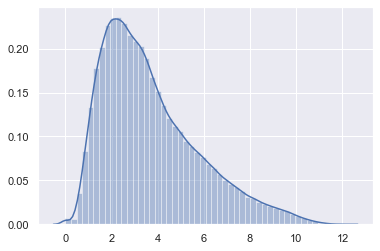

In [19]:
# Show distribution of distances between constituencies
dist_matrix = distance(demographic_data)
sns.distplot(np.ndarray.flatten(dist_matrix))

In [20]:
scores['Constituency'].iloc[np.where(dist_matrix == np.max(dist_matrix))[0]]

ons_id
E14000638           Christchurch
E14000555    Bethnal Green & Bow
Name: Constituency, dtype: object

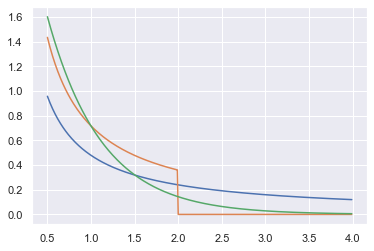

In [21]:
def norm(y):
    return y/(sum(y)*dx)

def cut(r, cutoff=1):
    r_cut = np.copy(r)
    r_cut[r>cutoff] = np.inf
    return r_cut

def exponent(r, base=math.e):
    return base**r

def contribution(r, func=lambda x:x, **kwargs):
    r = func(r, **kwargs)
    y = 1/r    
    return norm(y)

dx = 0.01
x=np.arange(0.5,4,dx)
y_cut = contribution(x, cut)

ax = sns.lineplot(x=x, y=contribution(x))
ax = sns.lineplot(x=x, y=contribution(x, cut, cutoff=2))
ax = sns.lineplot(x=x, y=contribution(x, exponent, base=5))

In [22]:
def examples_at_dist(dist, width=0.0001):
    dist_matrix = distance(demographic_data)
    pairs = np.where( np.abs(dist_matrix - dist) < width)
    for pair in np.array(pairs).T:
        if pair[0] > pair[1]:
            print(constits_name[pair[0]], ',', constits_name[pair[1]])
        
examples_at_dist(1)

Washington and Sunderland West , Houghton and Sunderland South
Shrewsbury and Atcham , Kettering
Cynon Valley , Doncaster North
Rutland and Melton , North East Bedfordshire
Warrington North , Ashford


In [23]:
def calc_dist_matrix(demographic_data, rescale=None, **kwargs):
    dist_matrix = distance(demographic_data)
    if rescale:
        dist_matrix = rescale(dist_matrix, **kwargs)
    return dist_matrix

def calc_score_matrix(scores):
    scores_scaled = preprocessing.scale(scores)
    score_matrix  = scores_scaled[:,np.newaxis] - scores_scaled
    return score_matrix

def calc_significance_matrix(demographic_data, constit_scores, 
                             rescale=None, **kwargs):
    assert np.all(demographic_data.index == constit_scores.index)
    dist_matrix  = calc_dist_matrix(demographic_data, rescale, **kwargs)
    score_matrix = calc_score_matrix(constit_scores)
    
    significance = np.zeros(dist_matrix.shape) 
    np.divide(score_matrix, dist_matrix, 
              where=dist_matrix!=0, out=significance)   
    return significance
    
def calc_campaign_conf(demographic_data, constit_scores, 
                       rescale=None, **kwargs):    
    significance = calc_significance_matrix(demographic_data, 
                                            constit_scores, 
                                            rescale, **kwargs)   
    
    confidences = np.sum(significance,1)
    confidences = preprocessing.scale(confidences)
    return confidences

In [24]:
results = pd.DataFrame({
    'constituency': constits_name,
    'uns':          calc_campaign_conf(demographic_data, scores['uns'],
                                       rescale=None),
    'uns_cut':      calc_campaign_conf(demographic_data, scores['uns'], 
                                       rescale=cut, cutoff=2),
    'uns_exp':      calc_campaign_conf(demographic_data, scores['uns'], 
                                       rescale=exponent, base=5),
                       }, index = constits_id)

results.sort_values(by='uns_exp', ascending=False).head(10)

,constituency,uns,uns_cut,uns_exp
ons_id,,,,
E14000958,Southport,4.368167,5.618753,5.236037
W07000078,Vale Of Glamorgan,2.818573,4.242221,4.108726
W07000063,Montgomeryshire,2.435930,2.952327,2.761862
E14000743,Hereford and South Herefordshire,1.978684,2.974146,2.699269
E14000961,St Austell and Newquay,1.845296,2.638269,2.559192
E14000762,Isle Of Wight,2.475303,2.298460,2.473369
E14000682,East Worthing and Shoreham,1.864418,2.661106,2.423487
E14000684,Eastbourne,2.104995,2.712328,2.408036
E14000614,Calder Valley,1.676107,2.535634,2.355555


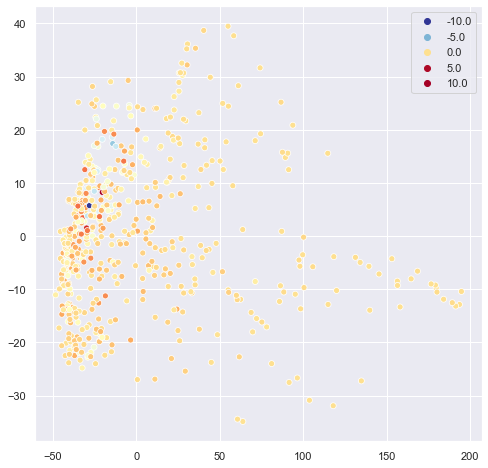

In [25]:
colours = np.array(results['uns_exp'])
visualise_demographics(demographic_data, colours=colours)

In [26]:
def calc_local_density(demographic_data, rescale=None, **kwargs):
    dist_matrix   = calc_dist_matrix(demographic_data, rescale, **kwargs)
    local_density = np.zeros(dist_matrix.shape)
    np.divide(np.ones(dist_matrix.shape), dist_matrix, 
              where=dist_matrix!=0, out=local_density)
    return pd.Series(np.sum(local_density,1),index=constits_id)

In [27]:
local_density = calc_local_density(demographic_data, 
                                   rescale=exponent, base=10)

uns_exp_density = results['uns_exp'] / local_density
uns_exp_density = preprocessing.scale(uns_exp_density)

results['uns_exp_density'] = uns_exp_density
results['density'] = local_density
results.sort_values('uns_exp_density',ascending=False).head(10)

,constituency,uns,uns_cut,uns_exp,uns_exp_density,density
ons_id,,,,,,
E14000958,Southport,4.368167,5.618753,5.236037,4.687696,11.316953
E14000634,Chingford and Woodford Green,2.279978,0.882070,1.262028,3.214255,3.956471
E14001003,Truro and Falmouth,2.386166,2.708772,2.303457,2.911464,7.958070
E14000762,Isle Of Wight,2.475303,2.298460,2.473369,2.841386,8.751725
E14000684,Eastbourne,2.104995,2.712328,2.408036,2.750438,8.796621
W07000078,Vale Of Glamorgan,2.818573,4.242221,4.108726,2.545866,16.189147
E14001056,Wycombe,1.712844,0.519277,0.803460,2.467449,3.264135
W07000051,Cardiff North,1.699890,0.949936,1.018164,2.454918,4.157032
W07000063,Montgomeryshire,2.435930,2.952327,2.761862,2.410671,11.478559


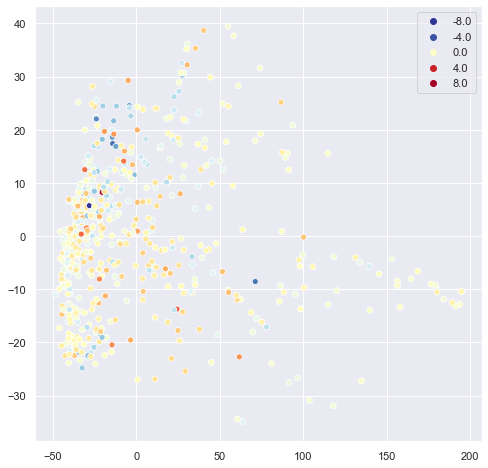

In [28]:
colours = np.array(results['uns_exp_density'])
visualise_demographics(demographic_data, colours=colours)

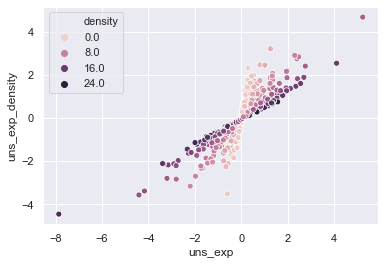

In [29]:
sns.scatterplot(x=results['uns_exp'],y=results['uns_exp_density'],
                hue=results['density'])

### Investigate a constituency's score

Using the data calculated above I can then present it in useful ways for campaign organisers.

Define a constituency of interest `coi` in the cell below to see where it's score comes from.

In [30]:
parties = ['lab','con','ld','ukip','grn','snp','pc']
colors = ['r','b','y','m','g','y','g']

In [31]:
import geopandas as gpd

map_df = gpd.read_file("data/map.shp")
map_df.index = census.index

def highlight_map(constits):
    highlight_map = map_df
    highlight_map['color'] = 0.9
    N = len(constits)
    for i,constit in enumerate(constits):
        highlight_map.loc[constit,'color'] = i*0.5/N
    f, ax = plt.subplots(1, figsize=(10, 10))
    ax = highlight_map.plot(column=highlight_map['color'],ax=ax,linewidth=0.1)
    ax.set_axis_off()

In [32]:
def graph_results(constits, years):
    if type(constits) == str:
        constits = [constits]
    if type(years) == int:
        years = [years]
    fig, ax = plt.subplots(len(constits),len(years),
                           figsize=(5*len(years),5*len(constits)),
                           sharey=True)

    for i,constit in enumerate(constits):
        name = id_to_name[constit]
        for j,year in enumerate(years):
            if len(constits) == 1:
                election_results[year][parties].loc[constit].plot.bar(color=colors,
                    title=name+' 20'+str(year),ax=ax[j])
            else:
                election_results[year][parties].loc[constit].plot.bar(color=colors,
                    title=name+' 20'+str(year),ax=ax[i,j])

In [33]:
def list_similar(constit, N=5):
    index = id_to_index[constit]
    dists = dist_matrix[index]
    close_indexes = np.argsort(dists)
    
    df = pd.DataFrame({'name': id_to_name[constit],
                       'distance': 0},
                      index = [constit])

    for i in range(1,N+1):
        j = close_indexes[i]
        df = df.append( pd.DataFrame({'name': constits_name[j],
                                     'distance': dists[j]},
                                     index = [constits_id[j]])
                      )
    return df

In [34]:
def list_significances(constit, significance_matrix, scores, N=5):
    index = id_to_index[constit]
    dists = dist_matrix[index]
    significances = significance_matrix[index]
    most_signif = np.argsort(-abs(significances))

    df = pd.DataFrame({'name': id_to_name[constit],
                       'distance': 0,
                       'election swing': scores.loc[constit],
                       'score contribution': 0,
                       },
                      index = [constit])
    
    for i in range(N):
        j = most_signif[i]
        df = df.append( pd.DataFrame({'name': constits_name[j],
                                      'distance': dists[j],
                                      'election swing': scores[constits_id[j]] - 0.079,
                                      'score contribution': significances[j]
                                     },
                                     index = [constits_id[j]])
                      )
    return df

In [35]:
# coi needs to a be an ONSID
coi = name_to_id['Chingford and Woodford Green']

In [36]:
significance_matrix = calc_significance_matrix(demographic_data, 
                                               scores['uns'], 
                                               rescale=exponent, 
                                               base=5)
list_significances(coi, significance_matrix, scores['uns'])

,name,distance,election swing,score contribution
E14000634,Chingford and Woodford Green,0.000000,0.019182,0.000000
E14000599,Bristol East,0.921562,-0.154791,0.505675
E14000621,Carshalton and Wallington,0.835257,-0.139568,0.487896
E14000558,Bexleyheath and Crayford,0.898574,-0.139059,0.437815
E14000548,Batley and Spen,1.374954,-0.207038,0.377858
E14000861,Northampton North,1.014040,-0.138552,0.361238


In [37]:
list_similar(coi)

,name,distance
E14000634,Chingford and Woodford Green,0.000000
E14000621,Carshalton and Wallington,0.835257
E14000692,"Enfield, Southgate",0.865352
E14000558,Bexleyheath and Crayford,0.898574
E14000599,Bristol East,0.921562
E14000861,Northampton North,1.014040


In [38]:
# use these onsids to view in the separate notebook: show_constits.ipynb
list_similar(coi,5).index

Index(['E14000634', 'E14000621', 'E14000692', 'E14000558', 'E14000599',
       'E14000861'],
      dtype='object')

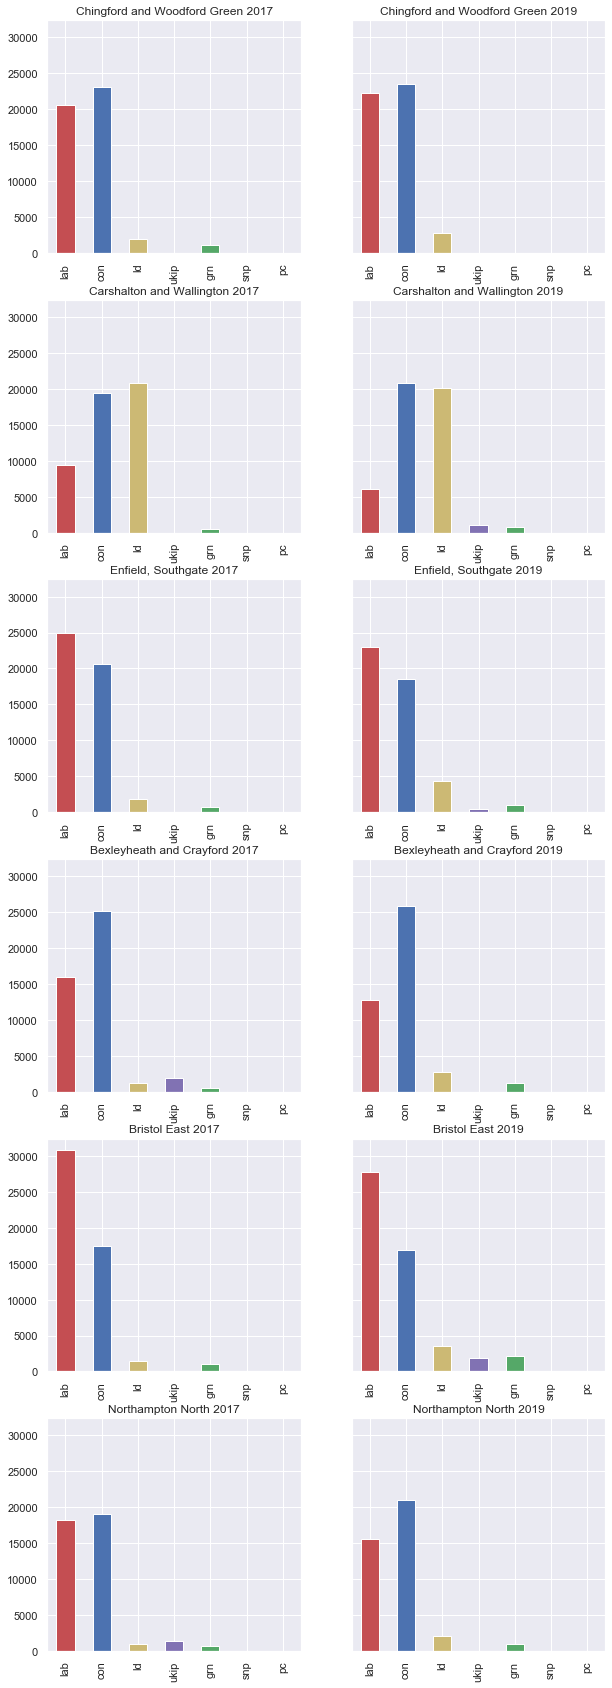

In [39]:
graph_results(list_similar(coi,5).index,[17,19])

## Sensitivity Analysis

In [40]:
from sklearn.metrics import r2_score

def sub_sample_features(features=features,subsample_size=1):
    from itertools import combinations
    return combinations(features,subsample_size)

df = results.copy()
print('Drop feature, r2_score')
for i,exclude in enumerate(sub_sample_features(subsample_size=1)):
    df[i] = calc_campaign_conf(demographic_data.drop(columns=list(exclude)), 
                               scores['uns'], 
                               rescale=exponent, base=5)
    print(exclude,'\t', r2_score(df['uns_exp'],df[i]))


Drop feature, r2_score
('c11PopulationDensity',) 	 0.993536756856526
('c11HouseOwned',) 	 0.9975598400478988
('c11CarsNone',) 	 0.9965800853596356
('c11EthnicityWhite',) 	 0.9887595180818703
('c11Unemployed',) 	 0.9824489455609497
('c11Retired',) 	 0.996875233305235
('c11FulltimeStudent',) 	 0.9589832525476397
('c11Age65to74',) 	 0.9952136140542799
('c11DeprivedNone',) 	 0.9781882434860725


In [41]:
def noise(array, factor=0.1):
    mean = np.mean(array, axis=0)
    std = np.std(array, axis=0)
    rng = np.random.RandomState()
    noise = rng.normal(mean, std * factor, size=array.shape)
    return array + noise
    
print('10% noise to demographics')
df = results.copy()
for i in range(5):    
    df[i] = calc_campaign_conf(noise(demographic_data), scores['uns'], 
                               rescale=exponent, base=5)
    print(r2_score(df['uns_exp'],df[i]))

print('\n 10% noise to score')
df = results.copy()
for i in range(5):    
    df[i] = calc_campaign_conf(demographic_data, noise(scores['uns']), 
                               rescale=exponent, base=5)
    print(r2_score(df['uns_exp'],df[i]))

10% noise to demographics
0.9908947075823662
0.9918252218322507
0.9923010176887339
0.9926537199985722
0.9868577152344026

 10% noise to score
0.9863776493268956
0.9846294240231287
0.9850640995320421
0.9864425731921834
0.9866496474845816


In [42]:
print('base, r2_score')

for i in range(1,11):
    a = calc_campaign_conf(demographic_data, scores['uns'], 
                           rescale=exponent, base=i)
    r2 = r2_score(results['uns_exp'], a)
    print(i,r2)

base, r2_score
1 0.5383937926156075
2 0.9219511936666296
3 0.9817296262280897
4 0.9970692854504402
5 1.0
6 0.9984181163976051
7 0.9949861259115358
8 0.9907741434496726
9 0.9862620510883875
10 0.9816802483589442


Given it stable to noise and parameter changes, have we actually trnasformed the data?

In [43]:
def compare(x1, x2):
    sns.scatterplot(x=x1,y=x2)
    print('r2_score = ',r2_score(preprocessing.scale(x1),
                                 preprocessing.scale(x2)))

r2_score =  0.8075124829074614


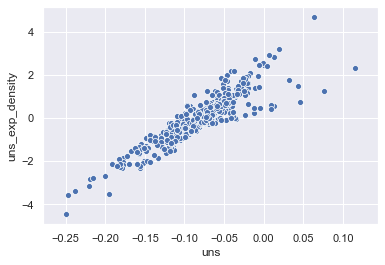

In [44]:
compare(scores['uns'],results['uns_exp_density'])

r2_score =  0.8334390242213359


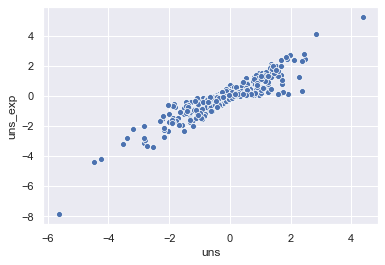

In [45]:
compare(results['uns'],results['uns_exp'])

r2_score =  0.4664244622599639


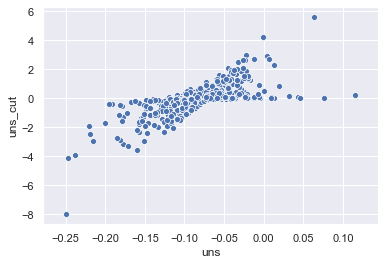

In [46]:
compare(scores['uns'],results['uns_cut'])